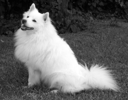

(100, 128) torch.float32 0.007843137718737125 1.0
(100, 128) float64 0.00784313725490196 1.0


In [1]:
import numpy as np
import PIL.Image
import torch
import torchvision.transforms.functional as tv
from IPython.display import display

img = PIL.Image.open("dog.jpg").convert("L")
img.thumbnail((128, 128))
display(img)

img_pt = tv.pil_to_tensor(img)
img_pt = tv.convert_image_dtype(img_pt, torch.float32)
img_pt = img_pt.squeeze(0)
print(tuple(img_pt.shape), img_pt.dtype, img_pt.min().item(), img_pt.max().item())

img_np = np.array(img) / 255.0
print(img_np.shape, img_np.dtype, img_np.min(), img_np.max())

0.5213618259803922


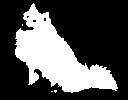

0.5213618


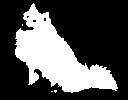

In [2]:
from skimage.filters.thresholding import threshold_otsu

print(threshold_otsu(img_np))
display(PIL.Image.fromarray(img_np > threshold_otsu(img_np, nbins=100)))

print(threshold_otsu(img_pt.numpy()))
display(PIL.Image.fromarray(img_pt.numpy() > threshold_otsu(img_pt.numpy())))

In [3]:
# Simplified from skimage.filters.thresholding.threshold_otsu
def threshold_otsu_np(img_np, bins=256):
    counts, bin_edges = np.histogram(img_np, bins=bins, range=None)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    # class probabilities for all possible thresholds
    weight1 = np.cumsum(counts)
    weight2 = np.cumsum(counts[::-1])[::-1]

    # class means for all possible thresholds
    mean1 = np.cumsum(counts * bin_centers) / weight1
    mean2 = (np.cumsum((counts * bin_centers)[::-1]) / weight2[::-1])[::-1]

    # Clip ends to align class 1 and class 2 variables:
    # The last value of ``weight1``/``mean1`` should pair with zero values in
    # ``weight2``/``mean2``, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

    idx = np.argmax(variance12)
    threshold = bin_centers[idx]
    return threshold


print(threshold_otsu(img_np))
print(threshold_otsu_np(img_np))

0.5213618259803922
0.5213618259803922


In [4]:
# Adapted from skimage.filters.thresholding.threshold_otsu
def threshold_otsu_pt(img_pt, bins=256):
    counts, bin_edges = torch.histogram(img_pt, bins=bins, range=None)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    # class probabilities for all possible thresholds
    weight1 = counts.cumsum(-1)
    weight2 = counts.flip(-1).cumsum(-1)

    # class means for all possible thresholds
    cbc = counts * bin_centers
    mean1 = cbc.cumsum(-1) / weight1
    mean2 = (cbc.flip(-1).cumsum(-1) / weight2).flip(-1)

    # Clip ends to align class 1 and class 2 variables:
    # The last value of ``weight1``/``mean1`` should pair with zero values in
    # ``weight2``/``mean2``, which do not exist.
    weight2 = weight2.flip(-1)
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

    idx = variance12.argmax(-1)
    threshold = bin_centers[idx]
    return threshold


print(threshold_otsu(img_pt.numpy()))
print(threshold_otsu_pt(img_pt).item())

0.5213618
0.5213618278503418


In [5]:
@torch.jit.script
def threshold_otsu_pt(imgs_pt, bins:int=256):
    H, W = imgs_pt.shape[-2:]
    x = imgs_pt.reshape(-1, H * W)
    B = x.shape[0]
    counts = x.new_empty((B, bins))
    bin_edges = x.new_empty((B, bins + 1))
    for b in range(B):
        counts[b], bin_edges[b] = torch.histogram(x[b], bins=bins, range=None)
    bin_centers = (bin_edges[:, 1:] + bin_edges[:, :-1]) / 2

    # class probabilities for all possible thresholds
    weight1 = counts.cumsum(-1)
    weight2 = counts.flip(-1).cumsum(-1)

    # class means for all possible thresholds
    cbc = counts * bin_centers
    mean1 = cbc.cumsum(-1) / weight1
    mean2 = (cbc.flip(-1).cumsum(-1) / weight2).flip(-1)

    # Clip ends to align class 1 and class 2 variables:
    # The last value of ``weight1``/``mean1`` should pair with zero values in
    # ``weight2``/``mean2``, which do not exist.
    weight2 = weight2.flip(-1)
    variance12 = weight1[:, :-1] * weight2[:, 1:] * (mean1[:, :-1] - mean2[:, 1:]) ** 2

    idx = variance12.argmax(-1, keepdim=True)
    threshold = bin_centers.gather(-1, idx)
    return threshold.reshape(imgs_pt.shape[:-2])

imgs_pt = torch.stack(
    [
        img_pt,
        img_pt / 2,
        img_pt / 2 + 0.5,
        img_pt / 3 + 0.4,
        img_pt * 5 + 0.1,
        img_pt - img_pt.min(),
    ]
).reshape(3, 2, *img_pt.shape)

print(
    np.array(
        [
            [
                threshold_otsu(imgs_pt[b, a].numpy())
                for a in range(imgs_pt.shape[1])
            ]
            for b in range(imgs_pt.shape[0])
        ]
    )
)
print(threshold_otsu_pt(imgs_pt).numpy())

[[0.5213618 0.2606809]
 [0.7606809 0.5737873]
 [2.706809  0.5135187]]
[[0.5213618 0.2606809]
 [0.7606809 0.5737873]
 [2.706809  0.5135187]]
